In [1]:
import json
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
%matplotlib inline

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [5]:
df_test.head()

,id,comment_text
0,6044863,==Orphaned non-free media (Image:41cD1jboEvL. ...
1,6102620,::Kentuckiana is colloquial. Even though the ...
2,14563293,"Hello fellow Wikipedians,\nI have just modifie..."
3,21086297,"AKC Suspensions \nThe Morning Call - Feb 24, 2..."
4,22982444,== [WIKI_LINK: Talk:Celts] ==


In [6]:
print 'Num Training Rows: {}'.format(len(df_train))
print 'Num Test Rows: {}'.format(len(df_test))

Num Training Rows: 95851
Num Test Rows: 226998


# Validation

## Null or empty comments

In [8]:
print 'Columns in Train set with Null values'
df_train.isnull().any()

Columns in Train set with Null values


id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [9]:
print 'Num Empty Comments in Train set: {}'.format(len(df_train[df_train.comment_text == '']))

Num Empty Comments in Train set: 0


In [10]:
print 'Columns in Test set with Null values'
df_test.isnull().any()

Columns in Test set with Null values


id              False
comment_text     True
dtype: bool

In [11]:
print 'Num Empty Comments in Test set: {}'.format(len(df_test[df_test.comment_text == '']))
print 'Num Null Comments in Test set: {}'.format(len(df_test[df_test.isnull().any(axis=1)]))

Num Empty Comments in Test set: 0
Num Null Comments in Test set: 1


## Repeated IDs?

In [12]:
print 'Num repeated IDs for Train: {}'.format(len(df_train.id.value_counts().where(lambda x: x > 1).dropna()))
print 'Num repeated IDs for Test: {}'.format(len(df_test.id.value_counts().where(lambda x: x > 1).dropna()))

Num repeated IDs for Train: 0
Num repeated IDs for Test: 0


## Class values

In [13]:
df_train.toxic.value_counts(dropna=False)

0    86614
1     9237
Name: toxic, dtype: int64

In [14]:
df_train.severe_toxic.value_counts(dropna=False)

0    94886
1      965
Name: severe_toxic, dtype: int64

In [15]:
df_train.obscene.value_counts(dropna=False)

0    90742
1     5109
Name: obscene, dtype: int64

In [16]:
df_train.threat.value_counts(dropna=False)

0    95546
1      305
Name: threat, dtype: int64

In [17]:
df_train.insult.value_counts(dropna=False)

0    91086
1     4765
Name: insult, dtype: int64

In [18]:
df_train.identity_hate.value_counts(dropna=False)

0    95037
1      814
Name: identity_hate, dtype: int64

## Class breakdown in Train

In [26]:
def get_comment_examples(df, n=20):
    for i, comment in enumerate(df.sample(n).comment_text):
        print '\x1b[1;34mExample {}\x1b[0m'.format(i+1)
        print comment

In [20]:
cond_clean = (df_train.toxic == 0) & (df_train.severe_toxic == 0) & (df_train.obscene == 0) \
                & (df_train.threat == 0) & (df_train.insult == 0) & (df_train.identity_hate == 0)
cond_toxic = (df_train.toxic == 1)
cond_severe_toxic = (df_train.severe_toxic == 1)
cond_obscene = (df_train.obscene == 1)
cond_threat = (df_train.threat == 1)
cond_insult = (df_train.insult == 1)
cond_identity_hate = (df_train.identity_hate == 1)

In [ ]:
num_clean = len(df_train[cond_clean])
num_toxic = len(df_train[cond_toxic])
num_severe_toxic = len(df_train[cond_severe_toxic])
num_obscene = len(df_train[cond_obscene])
num_threat = len(df_train[cond_threat])
num_insult = len(df_train[cond_insult])
num_identity_hate = len(df_train[cond_identity_hate])
class_counts = [num_clean, num_toxic, num_severe_toxic, num_obscene, num_threat, num_insult, num_identity_hate]

In [6]:
class_names = ['clean', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

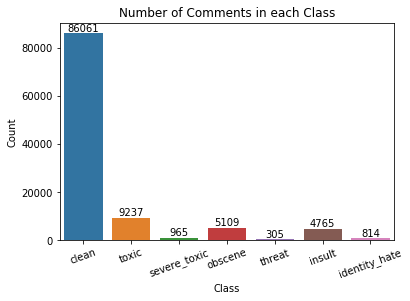

In [22]:
ax = sns.barplot(np.arange(7), class_counts)
plt.title('Number of Comments in each Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(np.arange(7), class_names, rotation=20)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

plt.show()

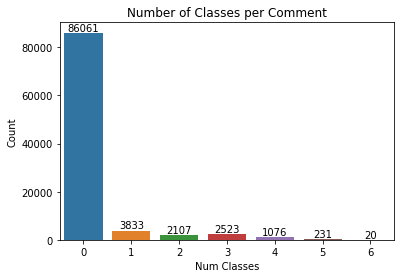

In [23]:
num_classes = df_train.iloc[:,2:].sum(axis=1).value_counts()
ax = sns.barplot(num_classes.index, num_classes.values)
plt.title('Number of Classes per Comment')
plt.xlabel('Num Classes')
plt.ylabel('Count')
plt.xticks(num_classes.index, num_classes.index)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

plt.show()

In [24]:
conds = [cond_toxic, cond_severe_toxic, cond_obscene, cond_threat, cond_insult, cond_identity_hate]
pairs = [[0 for c1 in conds] for c in conds]
for i, cond_1 in enumerate(conds):
    for j, cond_2 in enumerate(conds):
        pairs[i][j] = len(df_train[cond_1 & cond_2])
        
for i in range(len(conds)):
    for j in range(len(conds)):
        pairs[i][j] /= float(class_counts[j+1])

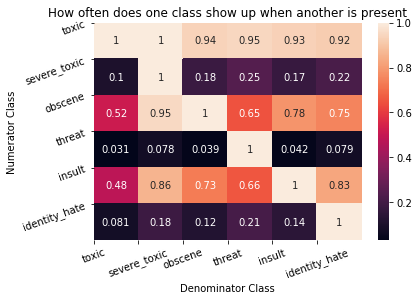

In [25]:
ax = sns.heatmap(pairs, annot=True)
plt.title('How often does one class show up when another is present')
plt.ylabel('Numerator Class')
plt.xlabel('Denominator Class')
plt.xticks(np.arange(6), class_names[1:], rotation=20)
plt.yticks(np.arange(6), class_names[1:], rotation=20)
plt.show()

## Language

In [26]:
def get_lang(row):
    try:
        return langdetect.detect(row['comment_text'].decode('utf-8'))
    except Exception as e:
        return ''

In [27]:
df_train['lang'] = df_train.apply(lambda x: get_lang(x), axis=1)

In [28]:
df_train.lang.value_counts()

en    93292
de      345
fr      219
af      215
so      164
id      163
et      146
cy      123
nl      121
da       98
no       97
sv       92
tl       90
it       85
tr       72
ca       66
es       64
hu       58
pt       54
ro       44
sw       40
fi       38
vi       35
pl       27
hr       23
sq       16
sl       14
sk       14
         13
cs       10
lt        8
lv        2
ta        1
bg        1
el        1
Name: lang, dtype: int64

In [29]:
get_comment_examples(df_train.loc[df_train.lang == 'de'], 5)

Example 1
"

ENRIQUE!!!!!!!!!!! WHATS UP?!?!?!?!??!!?!?!?!?!!?!?!!?!??!!?!   8:32, 15 December 2008 (UTC)"
Example 2
because john weiner sucks
Example 3
Why did you delete Guy Reschenthaler's page?
Example 4
NAZIS RAUS 

SHUT THIS NAZI NIXER UP
Example 5
September 19, 2005


In [30]:
get_comment_examples(df_train.loc[df_train.lang == 'fr'], 5)

Example 1
Request fulfilled by fr:WP user ©éréales Kille® on Fri, 21 Feb 2014 at 20:54
Example 2
Fine.  I will destroy you.

 Xchanter
Example 3
"
1996  Contributions /  "
Example 4
}}
{{translated page|fr|Jacques d'Allonville de Louville
Example 5
Well do you just like cheesy squirrel testicles?


In [31]:
get_comment_examples(df_train.loc[df_train.lang == 'af'], 5)

Example 1
I'm waiting Dinks, don't go to sleep like the last time...:)))
Example 2
talk to me, Goebbels.
Example 3
AHAHAHAH 

u wanna be an admin and ur 14??? keep dreaming KID
Example 4
06:54, 1 Sep 2004 (UTC)
Example 5
Hey i didnt do any vandalism. OK.


In [32]:
# All English, but interesting that some text classified as non-English are bad

# Examples

In [33]:
get_comment_examples(df_train[cond_clean])

Example 1
)

We're getting many attempts to use the passive voice in the article again.   reversion used it, and  edits continued to use it, only adding a preposition.  17:52, 7 February 2007 (UTC
Example 2
Great, thanks - a busy day I'll bet!
Example 3
"

 Re: Photos for 1999 Sydney hailstorm 

Hi! First of all, great work with the article! I do recall taking photos of my street covered with hails, however I wasn't sure if that was in 1999. However these photos are of extremely poor quality (taken with a phone camera back then....you can imagine how poor quality it is). Sorry I'm unable to help. Keep up with the great work!  
No worries - if you know anyone who has photos, please whack them over the head and get them to give them to you to upload ) Cheers, '''''' "
Example 4
Hey this is Karl and I would just like to day that I am back. Good Luck =>
Example 5
"
Hi there. I just asked  to do it whilst giving him the necessary details (message content, list of recipients, heading name an

In [34]:
get_comment_examples(df_train[cond_toxic])

Example 1
Japanese Bastard 

Fuck off you evil race.
Example 2
Why am I being blocked by an obvious anti-semite? Gareth Hughes, the so called anglican priest is a racist and an anti-semite.  Look at everyone of his posts regarding Assyrians?  He hates Assyrians, he is a jealous little twit with too much time on his hands and no real education... Anti-Semite!!!
Example 3
http://www.freeadulthotels.com This page is all about this adult porn links site
Example 4
"

 I AGREE WITH USER DARCYJ 

YOU REALLY NEED TO POLISH UP YOUR ENGLISH!!!!! OVER AND OVER AGAIN YOU MISPELL SIMPLE WORDS, FOR EXAMPLE- YOU WRITE IGNORE AS ""IGNOR"" OR SIMILIAR. HOW CAN YOU EXPECT TO AN EFFECTIVE EDITOR WHEN YOU CANNOT WRITE IN A GRAMMATICALLY AND SPELLING CORRECT FASHION!!! SECOND OF ALL, TO ME, YOU ARE A VERY BIG HYPOCRITE!!!!! YOU CLAIM THAT INDIAN ADMINISTRATORS ARE BEING PREDIJUICE TO YOU AND PLAYING ""FAVOURITES"" WITH YOU AND OTHER PAKISTANI WIKIPEDIANS WHEN YOU A HIGHLY RACIST PERSON YOURSELF!!!!!! YOU S

In [35]:
get_comment_examples(df_train[cond_severe_toxic])

Example 1
"I would like to extend a fat, robust FUCK YOU to the asshole who deleted my criticism of Schengen.  And you wonder why I continue to vandalize Wikipedia? Its because some fucking asshole from the Wiki community continually deletes whatever I post.  Yes I have used profanity, and yes I have often not followed protocols.  Yet when I have followed ""Wiki"" protocols, even kindly worded comments are promptly deleted by the assholes of Dickipedia.  To all of you at Wikipedia, I extend a fat and boisterous FUCK YOUfor deleting my comments -)

"
Example 2
Hey Njgw, you're fucking awake!

Rotting in front of your PC as usual I see.
Example 3
Hey you bitch 

When you deleted my page, I cried. You made an 18 year old cry.
Example 4
Hey fuck you Hal Turner sent a death threat to me in teh mail yesterday. He's a RACIST Don't let him use this is a launch pad for thi NAZI ANTICS!
Example 5
fok you 

YOU SUK BITSH FOCK YOU
Example 6
NIGGERS!
Dows really matter to label them? as long as the

In [36]:
get_comment_examples(df_train[cond_obscene])

Example 1
YOUR A  FAGGG GET A LIFE
Example 2
HEY ASS HOLE WHATS YOUR PROBLEM!!!!
Example 3
senseless fucking of my mother
Example 4
Do U own Wikipedia? 

 Was believing wikipedia was an open source. Didnt know people like Jeff G and Bg(fucking) white own it!!!!!!!!!
Example 5
Demonte Morton 

U bastard stop deletin' my shit u white trash cracker muthafucker. Fuck u u racist bitch. I hope u die.
Example 6
Fuck You
All I Did Was Put Stuff On My user Page And Your Deleted It SO Fuck You And Fuck Wikipedia
Example 7
why did you delete SopCast you faggot?
Example 8
Fine
Fine.  Carter Page sucks anyway.
Example 9
(ONLY IF YOU REPORTED ME), then you can kiss my ass you fucken bitch.
Example 10
You're an ass. That was not a clip of the real game.
-Jutras
Example 11
LOL; charles, you are a real fag aren't you? siding with chinks?? 
go fuck yourself, asswipe! we don't need no chinks in here. 

FAG
Example 12
You seem to be a pretty poor administrator 
Hiya, thanks for the 'last warning'. Upon lo

In [37]:
get_comment_examples(df_train[cond_threat])

Example 1
Helo 

Wassup I dnt know who the shit u r but ima whop yo ass for blocking me
Example 2
"

 Niggard PLEASE! 

The niggardly nigger niggerly niggered a nickel from his nigga! He was heard saying, ""can a nigga spare a nickel?""

I firmly believe this is proof the the politically correct should be impaled on stakes and left for dead. Or placed into death camps and given no showers for months and then informing them that ""showers"" are now available... turn on the gas, dig pits, and bulldoze their corpses into them. Burn them, piss on them, then plow them over. 

 PEOPLE! QUIT PANDERING TO LAZY, STUPID, GOOD-FOR-NOTHING, WELFARE-GRUBBING, CRACK-SMOKING, FILTHY, STINKY NIGGERS! "
Example 3
You are such a fucking hypocrite. 

I hope you get raped and killed by some lunatic like Andrew Morrow.
Example 4
Personal Attack Number 2 

This is another personal attack about you being a massive donkey dick sucking homosexual. This is a concerned plea that you should at once drown yourself

In [38]:
get_comment_examples(df_train[cond_insult])

Example 1
Guess WHat

Your an ass
Example 2
I did use the sandbox. Idiot.
Example 3
SHUT YOUR FAT FACE YOU ASS>
Example 4
The DoS was my entire Internet connection shutting down momentarily just after posting. You're an asshole. Ban me. You're still an asshole. You know I'm right. But you'll fight tooth and nail for your own opinion despite a third party source that indicates the validity of the source material. May all your edits be attacked by people as resolutely brick-headed as you. 71.102.18.173
Example 5
Scope
Please see the link above, as I'm sure you are a fucking spastic
Example 6
Listen up. 

OK, listen up you god damn jerk. I'm really sick and tired of your shit. I'm sick of you stalking me all over wikipedia because I'm editing a page. Just because YOU don't like the edits I make, doesn't mean you have to bully and global block me each time I make an edit OK?? I'm not hurting and offending anyone, so why treat me like a terrorist??

I've noticed I'm not the only one you bul

In [39]:
get_comment_examples(df_train[cond_identity_hate])

Example 1
Roman Catholics

i'm not accusing you but i think you're a fenian. You are ugly and probably the seventh born in a family. You have probably been molested at some point by a priest. You disgust me. SIEG HEIL!
Example 2
EVula likes having gay sex with men!
Example 3
He was a racial Jew, you fool. If you want to argue that, do it in the appropriate discussion page, under a new, appropriate heading, Mr. Censor Tyrant.
Example 4
You fascit Nazi! You socialist bastard! You filthy Hippy! 

You dare touch my edits again and I'll go to where you live and kick your ass in person. It shouldn't be hard to find. Communes smell worse than slaughter houses. I make edits. I don't vandilaze. Get off your high horse.
Example 5
what up my nigga?????
Example 6
Gay
I would like to request the removal of this article on the grounds that it is mad gay.
Example 7
intervei CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, 

In [40]:
print 'Comedy gold.'
get_comment_examples(df_train[cond_toxic & cond_severe_toxic & cond_obscene & cond_insult & cond_threat & cond_identity_hate])

Comedy gold.
Example 1
I am going to murder ZimZalaBim ST47 for being evil homosexual jews.
Example 2
FUCK YOU!!!!!!!!!!!! YOU FUCKING NIGGER BAG OF SHIT I HOPE YOU DIE IN A HORRIBLE FIRE WITH YOUR GAY ASS KIDS I WILL SLIT THEIR THROAT YOU MOTHERFUCKER DONT YOU EVER THINK OF BANNING ME AGAIN OR I WILL RAPE YOU ANALLY!!!!!
Example 3
I hit a jack off all day, after the rape my mother, destroy the vagina until it hurts, then when you start bleeding I start to have sex with the mother of you Americans motherfuckers

They give the anus and the vagina every day for free, I'll sing a piece of music of Brazil who have money who slips into the vagina is not you jack off 10 year old girl already has at the vagina

The Brazilian soccer team is the best in the world humbles Americans

I get a boner from hell just eat your mother, that once again put out my articles you sons of bitches

vagina of mother north americans
Example 4
YOURE A FRREAKING JEW, AND PLEAZE COMMIT SUICIDE.
Example 5
fuck you h

# Feature ideas

In [41]:
import spacy
nlp = spacy.load('en')

In [42]:
df_train['clean'] = df_train.apply(lambda x: int(all(x[tag] == 0 for tag in class_names[1:])), axis=1)

In [43]:
def plot_feature(df, feat_name, lv_ylim=None, hist_xlim=None):
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    sns.lvplot(x='clean', y=feat_name, data=df_train, label='Clean')
    if lv_ylim:
        plt.ylim(lv_ylim)
    
    plt.subplot(122)
    if hist_xlim:
        bins = np.linspace(hist_xlim[0], hist_xlim[1], 21)
    else:
        bins = 'auto'
    
    plt.hist(df_train[cond_clean][feat_name], bins, linewidth=2, normed=True, histtype='step', label='Clean')
    plt.hist(df_train[cond_toxic][feat_name], bins, normed=True, histtype='step', label='Toxic')
    plt.hist(df_train[cond_severe_toxic][feat_name], bins, normed=True, histtype='step', label='Severe Toxic')
    plt.hist(df_train[cond_obscene][feat_name], bins, normed=True, histtype='step', label='Obscene')
    plt.hist(df_train[cond_threat][feat_name], bins, normed=True, histtype='step', label='Threat')
    plt.hist(df_train[cond_insult][feat_name], bins, normed=True, histtype='step', label='Insult')
    plt.hist(df_train[cond_identity_hate][feat_name], bins, normed=True, histtype='step', label='Identity Hate')
    plt.xlabel(feat_name)
    plt.legend()
    if hist_xlim:
        plt.xlim(hist_xlim)
        
    plt.show()

## Num words

In [44]:
df_train['num_words'] = df_train.apply(lambda x: len(x['comment_text'].split()), axis=1)

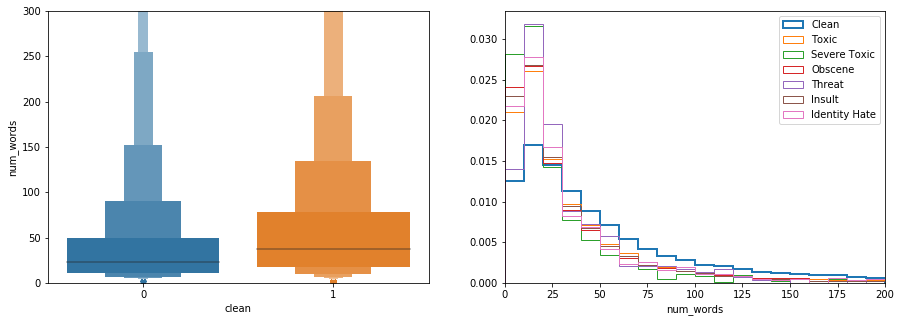

In [45]:
plot_feature(df_train, 'num_words', lv_ylim=(0, 300), hist_xlim=(0, 200))

## Num Chars

In [46]:
df_train['num_chars'] = df_train.apply(lambda x: len(x['comment_text']), axis=1)

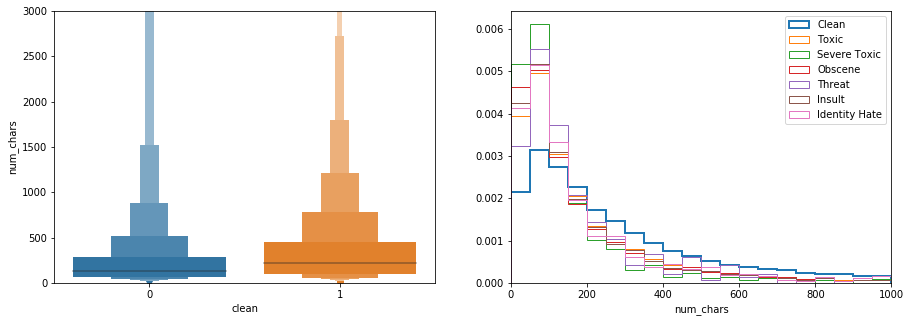

In [47]:
plot_feature(df_train, 'num_chars', lv_ylim=(0, 3000), hist_xlim=(0, 1000))

## Avg Word Length

In [48]:
df_train['avg_word_len'] = df_train.apply(lambda x: x['num_chars'] / float(x['num_words']) , axis=1)

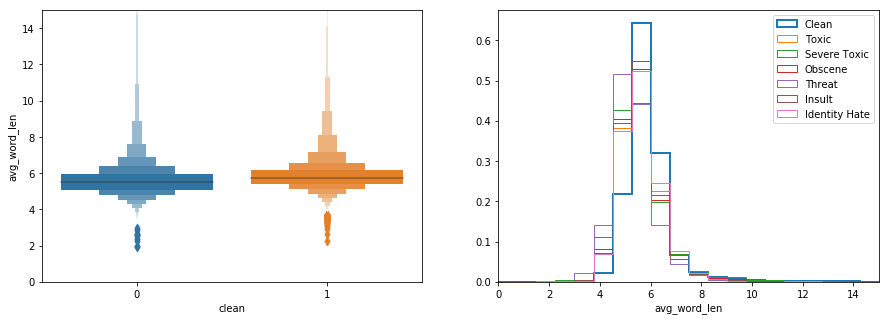

In [49]:
plot_feature(df_train, 'avg_word_len', lv_ylim=(0, 15), hist_xlim=(0, 15))

## Num Capitalized Characters

In [50]:
df_train['cap_chars'] = df_train.apply(lambda x: sum(1 for c in x['comment_text'] if c.isupper()), axis=1)

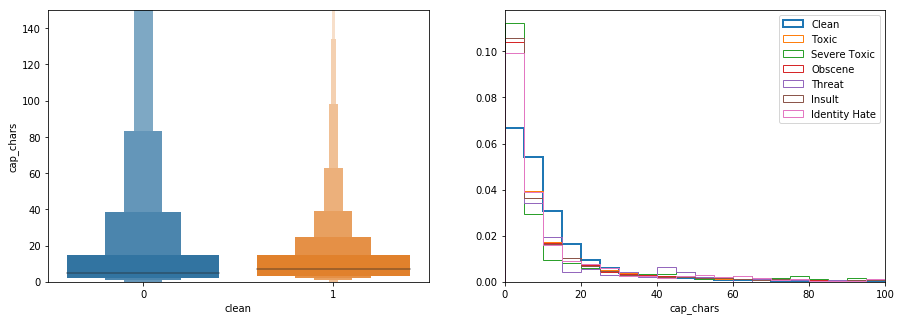

In [51]:
plot_feature(df_train, 'cap_chars', lv_ylim=(0, 150), hist_xlim=(0, 100))

## Ratio Capitalized Characters with non-whitespace chars

In [52]:
df_train['ratio_cap_chars'] = df_train.apply(lambda x: x['cap_chars'] / sum(1. for c in x['comment_text'] if not c.isspace()), axis=1)

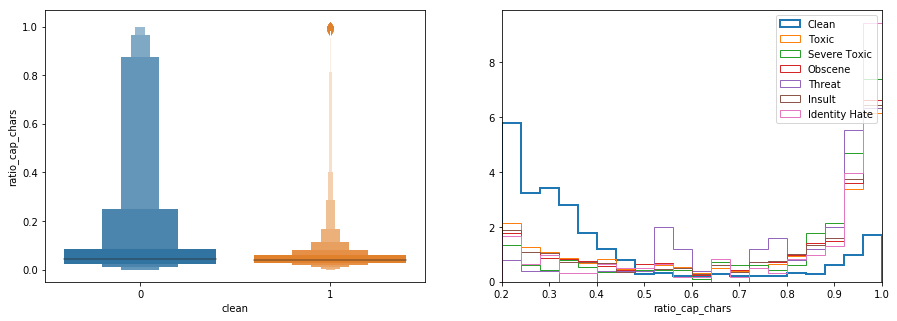

In [53]:
plot_feature(df_train, 'ratio_cap_chars', hist_xlim=(0.2, 1))

In [54]:
# The bump at ~0.8 is only present for non-clean comments

## Num Punctuation

In [55]:
df_train['num_punc'] = df_train.apply(lambda x: sum(1 for c in x['comment_text'] if c in string.punctuation), axis=1)

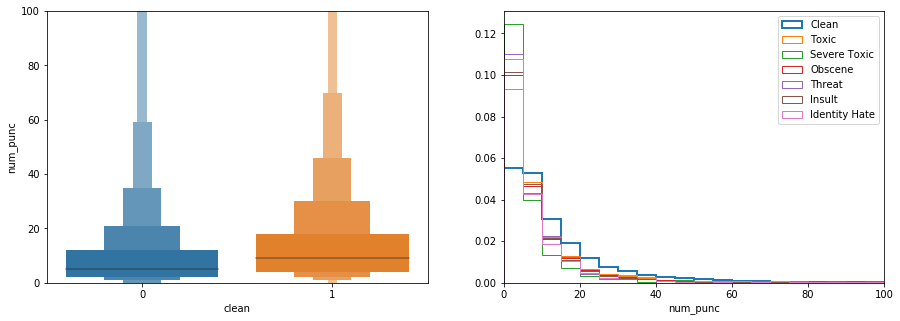

In [56]:
plot_feature(df_train, 'num_punc', lv_ylim=(0, 100), hist_xlim=(0, 100))

In [57]:
# Extreme values

## Num Exclamation Marks

In [58]:
df_train['num_excl'] = df_train.apply(lambda x: sum(1 for c in x['comment_text'] if c == '!'), axis=1)

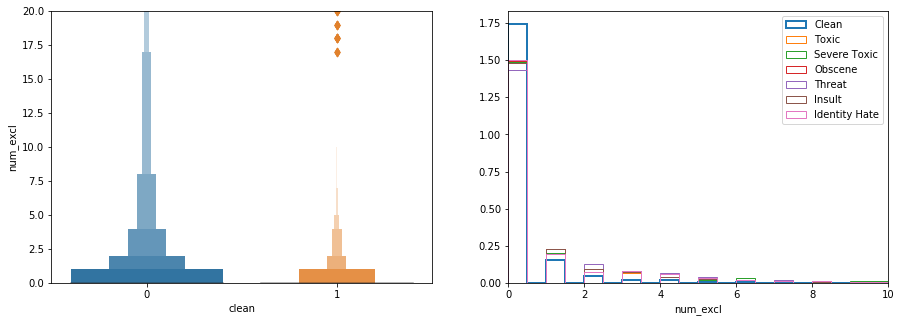

In [59]:
plot_feature(df_train, 'num_excl', lv_ylim=(0, 20), hist_xlim=(0, 10))

In [60]:
# Extreme values

## Ratio of Exclamation Marks to Words

In [61]:
df_train['ratio_excl'] = df_train.apply(lambda x: float(x['num_excl']) / x['num_words'], axis=1)

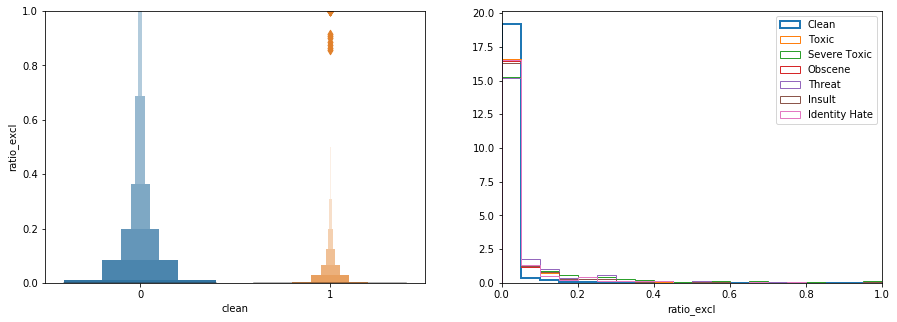

In [62]:
plot_feature(df_train, 'ratio_excl', lv_ylim=(0, 1), hist_xlim=(0, 1))

In [63]:
# Extreme values

## Num Question Marks

In [64]:
df_train['num_q'] = df_train.apply(lambda x: sum(1 for c in x['comment_text'] if c == '?'), axis=1)

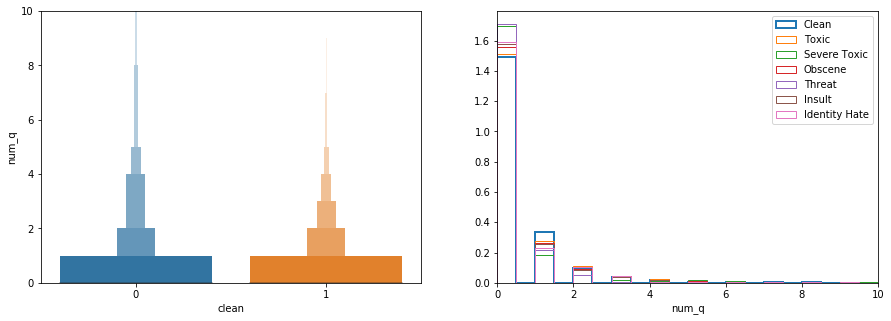

In [65]:
plot_feature(df_train, 'num_q', lv_ylim=(0, 10), hist_xlim=(0, 10))

In [66]:
# Extreme values

## Ratio of Question Marks to Words

In [67]:
df_train['ratio_q'] = df_train.apply(lambda x: float(x['num_q']) / x['num_words'], axis=1)

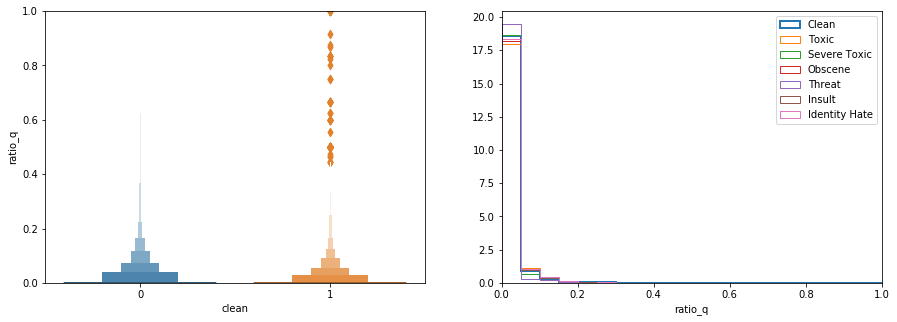

In [68]:
plot_feature(df_train, 'ratio_q', lv_ylim=(0, 1), hist_xlim=(0, 1))

In [69]:
# Max of ~6 & 8

## Num Next Lines

In [70]:
df_train['num_lines'] = df_train.apply(lambda x: sum(1 for c in x['comment_text'] if c == '\n'), axis=1)

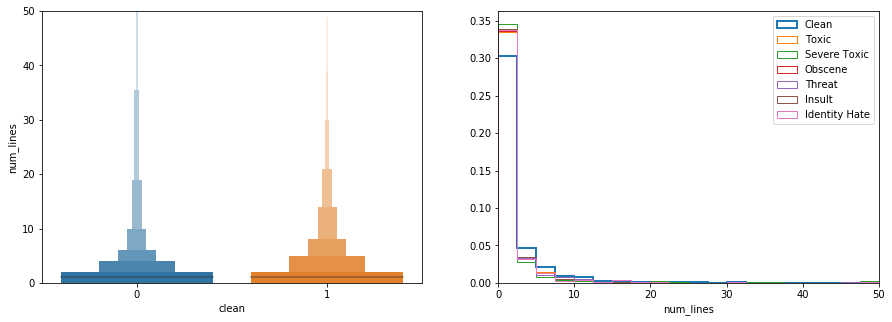

In [71]:
plot_feature(df_train, 'num_lines', lv_ylim=(0, 50), hist_xlim=(0, 50))

In [72]:
# Extreme values

## Excessive Reptition of Character

In [73]:
def get_num_excessive_char(row):
    count = 0
    max_i = len(row['comment_text'])
    if max_i < 2:
        return count
    
    prev_char = row['comment_text'][0]
    prev_prev_char = None
    i = 1
    
    while i < max_i:
        cur_char = row['comment_text'][i]
        if cur_char.isspace():
            prev_char = None
            prev_prev_char = None
            i += 1
        elif prev_char is None:
            prev_char = cur_char
            i += 1
        elif cur_char != prev_char:
            prev_char = cur_char
            prev_prev_char = None
            i += 1
        elif prev_prev_char is None:
            prev_prev_char = prev_char
            i += 1
        else:
            count += 1
            prev_char = None
            prev_prev_char = None

            while i < max_i and row['comment_text'][i] == cur_char:
                i += 1
        
    return count

In [74]:
df_train['num_excess_char'] = df_train.apply(lambda x: get_num_excessive_char(x), axis=1)

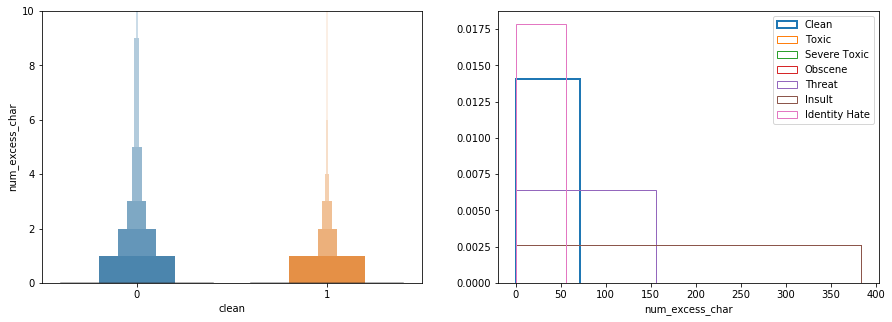

In [75]:
plot_feature(df_train, 'num_excess_char', lv_ylim=(0, 10))

In [76]:
# Extreme values, anything greater than 100 is definitely not clean

## Repeated Words

In [77]:
def count_repeated_words(row):
    text = ''.join([c.lower() for c in row['comment_text'] if c not in string.punctuation])
    words = text.split()
    word_count = {}
    for w in words:
        try:
            word_count[w] += 1
        except KeyError:
            word_count[w] = 1
    
    return len([1 for k, v in word_count.iteritems() if v > 1])

In [78]:
df_train['repeated_words'] = df_train.apply(lambda x: count_repeated_words(x), axis=1)

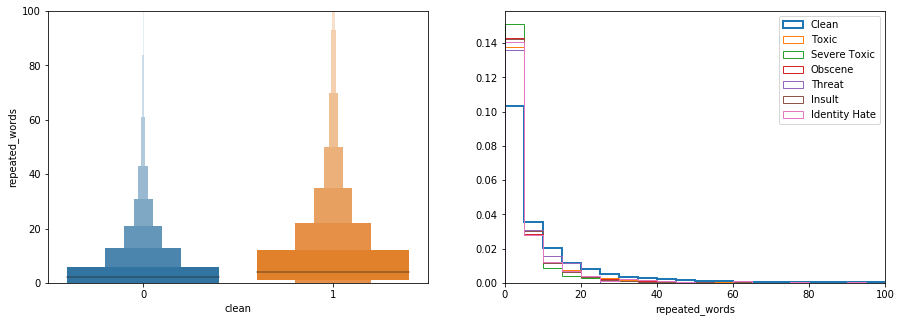

In [79]:
plot_feature(df_train, 'repeated_words', lv_ylim=(0, 100), hist_xlim=(0, 100))

In [80]:
# Need to do this after stripping stop words

# Tokenization

In [81]:
def spacy_words(row):
    tokens = nlp(unicode(row['comment_text'].decode('utf-8')))
    words = [t for t in tokens if not t.is_space and not t.is_punct]
    return words

In [82]:
df_train['spacy_words'] = df_train.apply(lambda x: spacy_words(x), axis=1)

## Num Spacy Words

In [83]:
df_train['num_spacy_words'] = df_train.apply(lambda x: len(x['spacy_words']), axis=1)

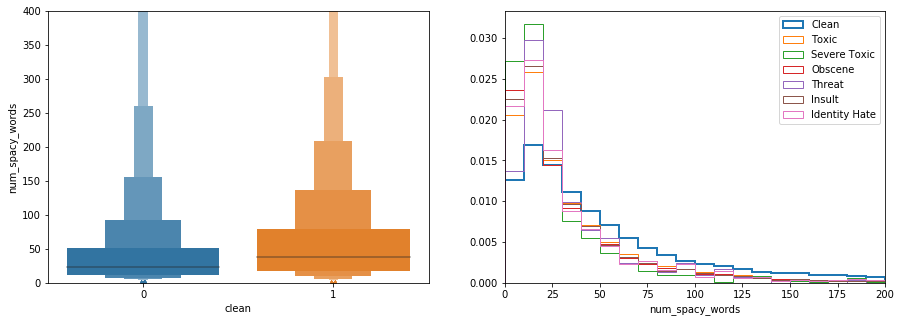

In [84]:
plot_feature(df_train, 'num_spacy_words', lv_ylim=(0, 400), hist_xlim=(0, 200))

## Num Non-Stop Words

In [85]:
df_train['num_non_stop'] = df_train.apply(lambda x: sum([1. for t in x['spacy_words'] if not t.is_stop]), axis=1)

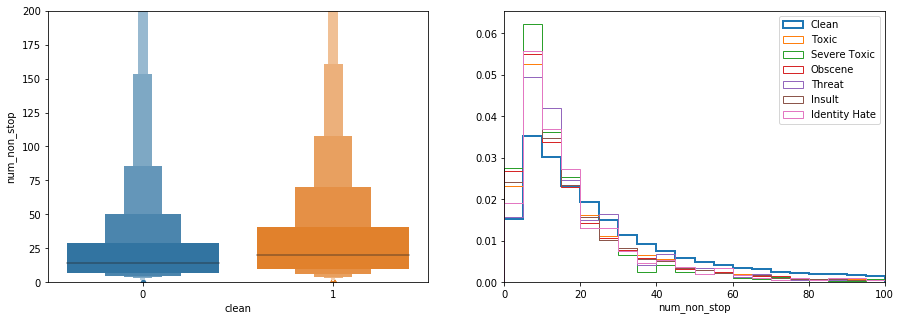

In [86]:
plot_feature(df_train, 'num_non_stop', lv_ylim=(0, 200), hist_xlim=(0, 100))

## Num Out of Dictionary

In [87]:
df_train['num_oov'] = df_train.apply(lambda x: sum([1. for t in x['spacy_words'] if unicode(t) not in nlp.vocab]), axis=1)

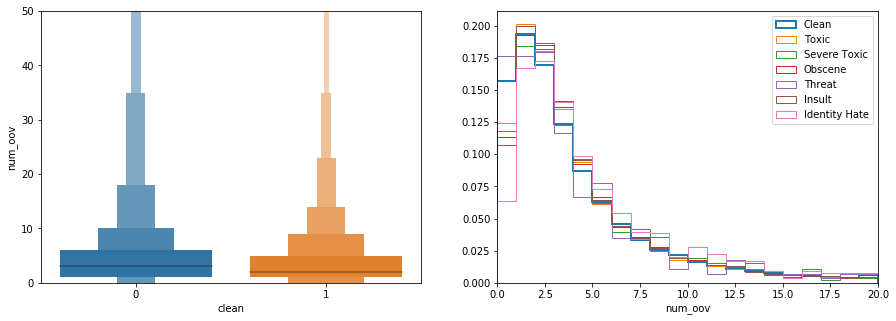

In [88]:
plot_feature(df_train, 'num_oov', lv_ylim=(0, 50), hist_xlim=(0, 20))

## Ratio Out of Dictionary

In [89]:
def ratio(numerator, denominator):
    if numerator == 0:
        return 0.
    elif denominator == 0:
        return 1.
    else:
        return float(numerator) / denominator

In [90]:
df_train['ratio_oov'] = df_train.apply(lambda x: ratio(x['num_oov'], x['num_non_stop']), axis=1)

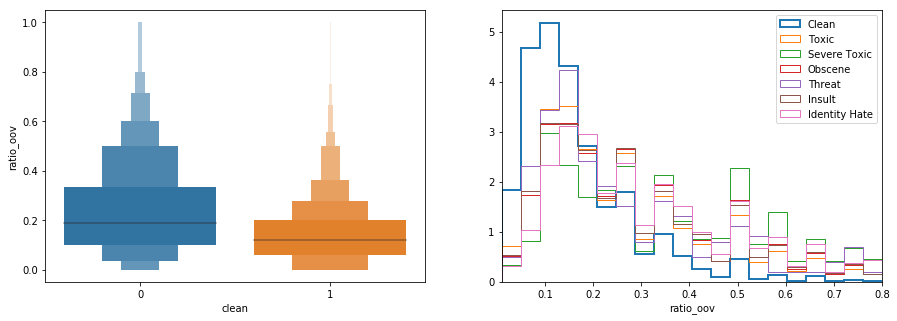

In [91]:
plot_feature(df_train, 'ratio_oov', hist_xlim=(0.01, 0.8))

## Num You

In [92]:
you_words = {'you', 'your', 'u', 'ur'}

In [93]:
def count_you(row):
    return sum(1. for t in row['spacy_words'] if t.lower_ in you_words)

In [94]:
df_train['num_you'] = df_train.apply(lambda x: count_you(x), axis=1)

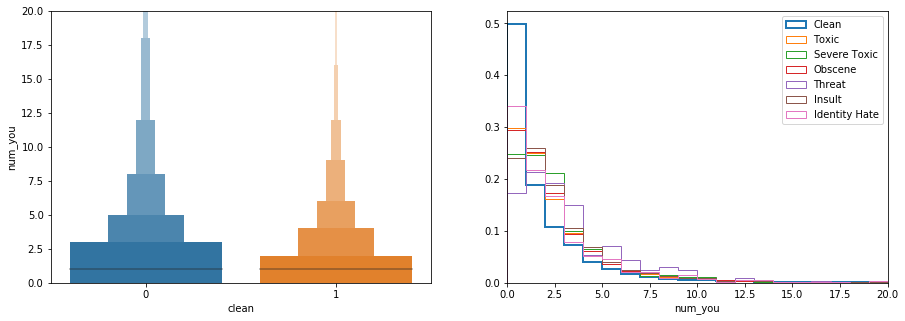

In [95]:
plot_feature(df_train, 'num_you', lv_ylim=(0, 20), hist_xlim=(0, 20))

## Ratio You to Words

In [96]:
df_train['ratio_you'] = df_train.apply(lambda x: ratio(x['num_you'], x['num_spacy_words']), axis=1)

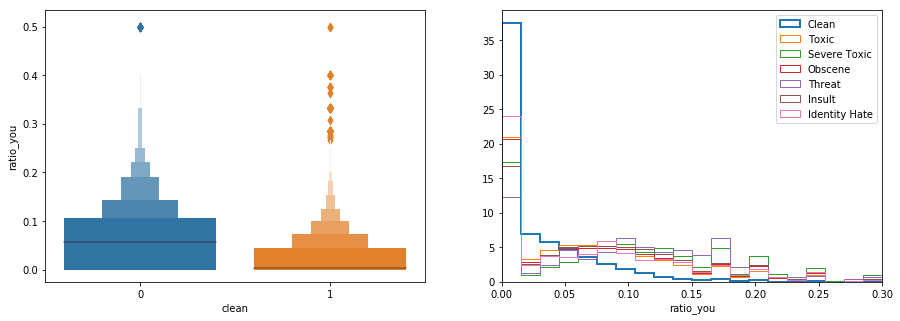

In [97]:
plot_feature(df_train, 'ratio_you', hist_xlim=(0, 0.3))

## Repeated Non-Stop Spacy Words

In [127]:
def repeated_spacy_words(row):
    word_count = {}
    for _w in row['spacy_words']:
        if _w.is_stop:
            continue
            
        w = _w.lower_
        try:
            word_count[w] += 1
        except KeyError:
            word_count[w] = 1
    
    return len([1 for k, v in word_count.iteritems() if v > 1])

In [128]:
df_train['repeat_spacy_words'] = df_train.apply(lambda x: repeated_spacy_words(x), axis=1)

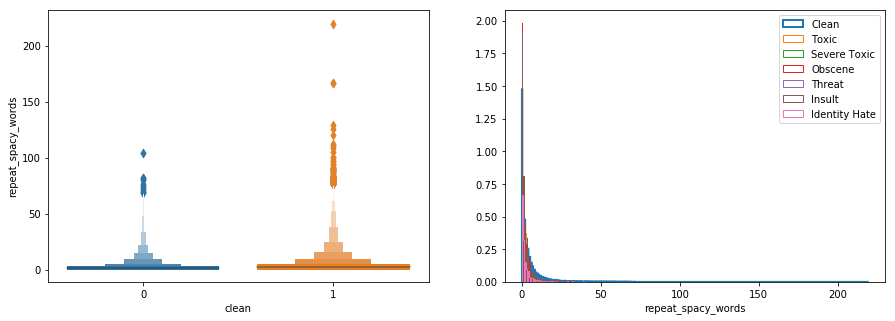

In [132]:
plot_feature(df_train, 'repeat_spacy_words', lv_ylim=(0, 50), hist_xlim=(0, 50))

## Ratio Repeated Words

In [229]:
df_train['ratio_repeat_spacy_words'] = df_train.apply(lambda x: ratio(x['repeat_spacy_words'], x['num_spacy_words']), axis=1)

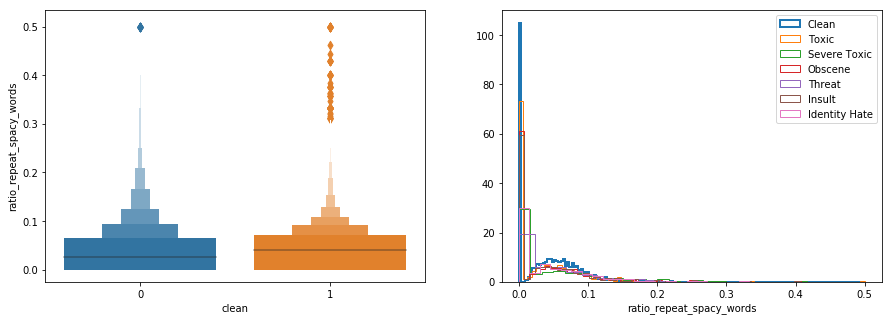

In [230]:
plot_feature(df_train, 'ratio_repeat_spacy_words')

## Unique Non-Stop Spacy Words

In [231]:
def unique_spacy_words(row):
    word_count = set()
    for _w in row['spacy_words']:
        if _w.is_stop:
            continue
            
        w = _w.lower_
        word_count.add(w)
    
    return len(word_count)

In [232]:
df_train['unique_spacy_words'] = df_train.apply(lambda x: unique_spacy_words(x), axis=1)

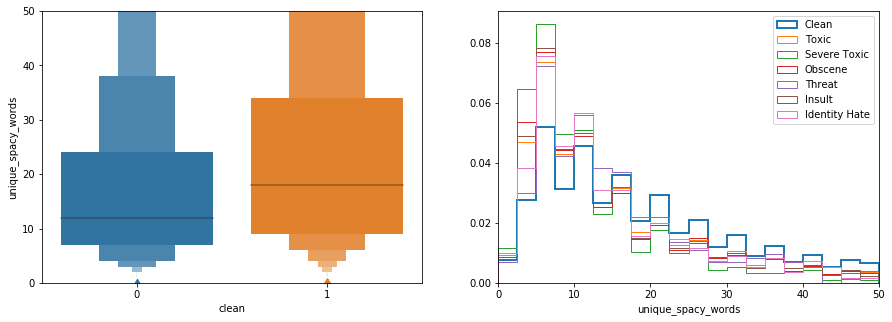

In [234]:
plot_feature(df_train, 'unique_spacy_words', lv_ylim=(0, 50), hist_xlim=(0, 50))

## Ratio Unique Spacy Words

In [236]:
df_train['ratio_unique_spacy_words'] = df_train.apply(lambda x: ratio(x['unique_spacy_words'], x['num_spacy_words']), axis=1)

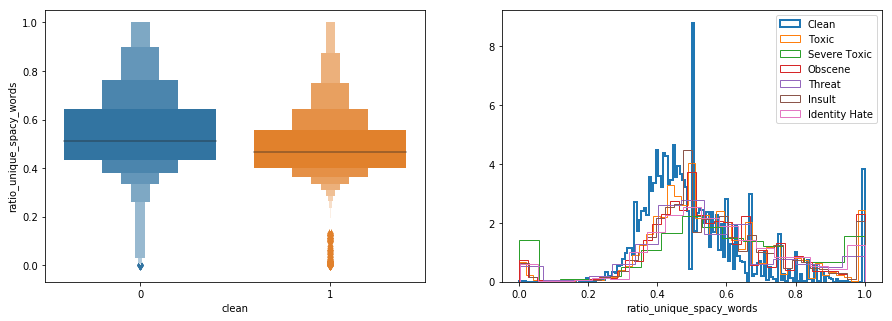

In [237]:
plot_feature(df_train, 'ratio_unique_spacy_words')

# Countries

In [153]:
with open('countries.json', 'r') as f:
    # Found here: http://www.myenglishpages.com/site_php_files/vocabulary-lesson-countries-nationalities.php
    countries = set(json.load(f))

In [157]:
def in_country(row):
    lowered_text = row['comment_text'].decode('utf-8').lower()
    return sum([lowered_text.count(c) for c in countries])

In [158]:
df_train['country_mentions'] = df_train.apply(lambda x: in_country(x), axis=1)

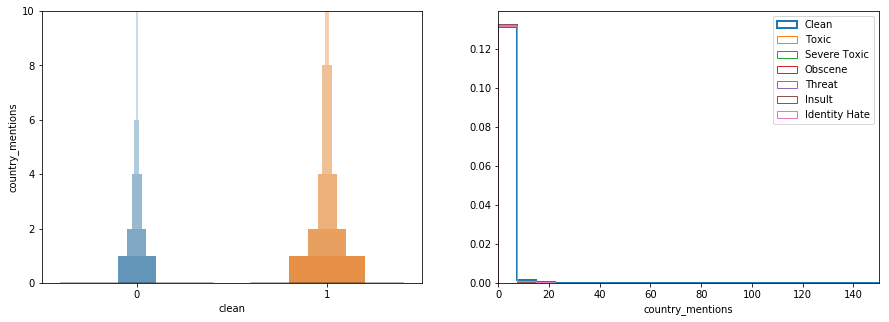

In [160]:
plot_feature(df_train, 'country_mentions', lv_ylim=(0, 10), hist_xlim=(0, 150))

# Bad Words

In [165]:
with open('bad_words.json', 'r') as f:
    # Found here: https://github.com/web-mech/badwords-list/blob/master/lib/array.js
    bad_words = set(json.load(f))

In [168]:
def bad_word(row):
    return sum([1. for w in row['spacy_words'] if w.lower_ in bad_words])

In [169]:
df_train['bad_words'] = df_train.apply(lambda x: bad_word(x), axis=1)

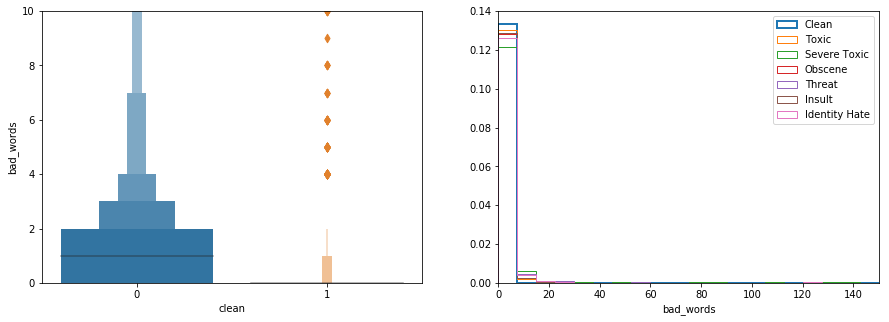

In [171]:
plot_feature(df_train, 'bad_words', lv_ylim=(0, 10), hist_xlim=(0, 150))

# URL

In [174]:
df_train['num_url'] = df_train.apply(lambda x: x['comment_text'].count('http://'), axis=1)

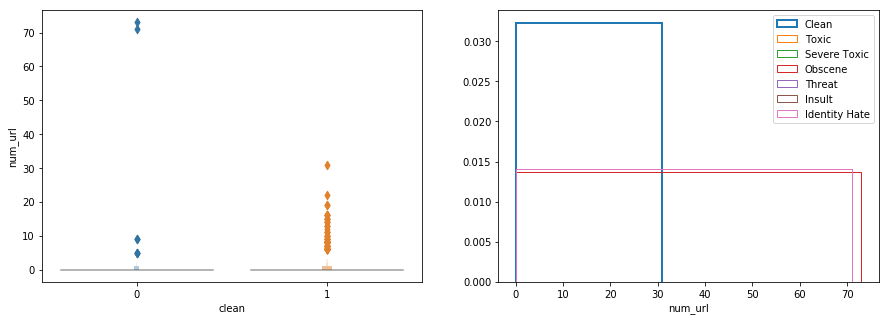

In [185]:
plot_feature(df_train, 'num_url')

# Spacy URL

In [183]:
df_train['num_spacy_url'] = df_train.apply(lambda x: sum([1. for t in x['spacy_words'] if t.like_url]), axis=1)

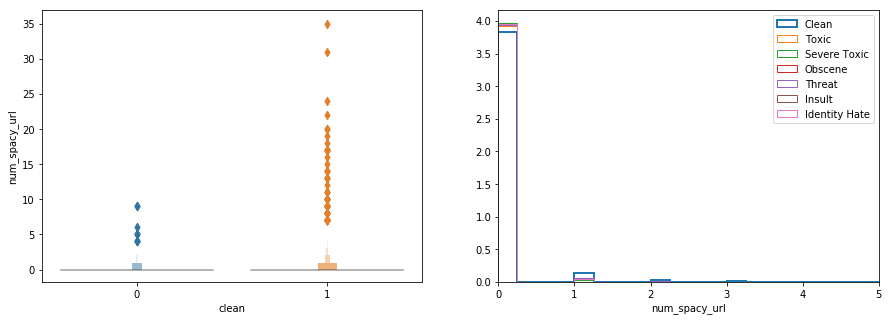

In [238]:
plot_feature(df_train, 'num_spacy_url')

# Sentiment Analysis

In [218]:
from nltk.sentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()
vader_neg = []
vader_pos = []
vader_neu = []
vader_compound = []
for index, series in df_train.iterrows():
    d = vader_analyzer.polarity_scores(series.comment_text.decode('utf-8'))
    vader_neg.append(d['neg'])
    vader_pos.append(d['pos'])
    vader_neu.append(d['neu'])
    vader_compound.append(d['compound'])

In [225]:
df_train['vader_neg'] = vader_neg
df_train['vader_pos'] = vader_pos
df_train['vader_neu'] = vader_neu
df_train['vader_compound'] = vader_compound

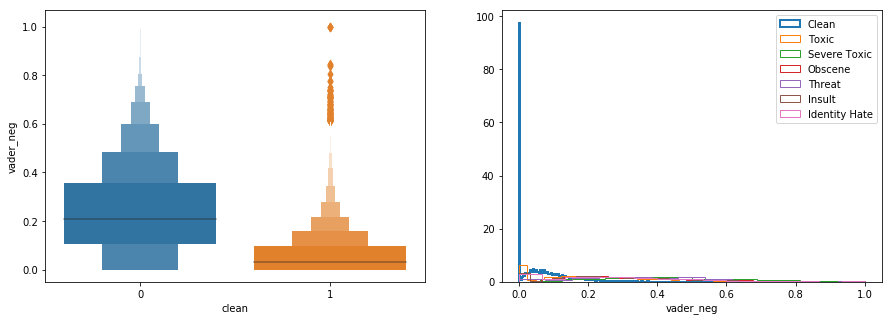

In [226]:
plot_feature(df_train, 'vader_neg')#, lv_ylim=(0, 30), hist_xlim=(0, 10))

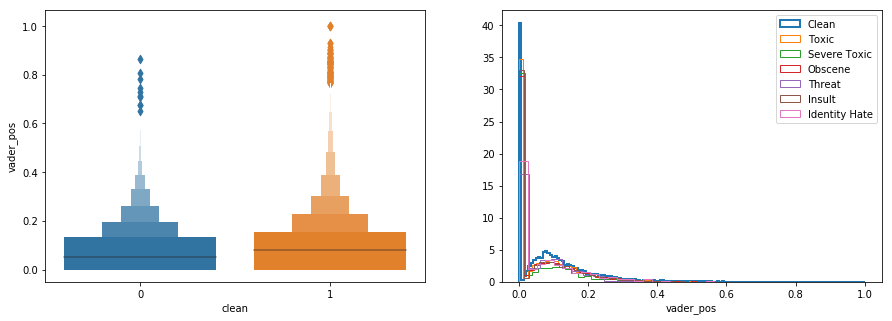

In [227]:
plot_feature(df_train, 'vader_pos')#, lv_ylim=(0, 30), hist_xlim=(0, 10))

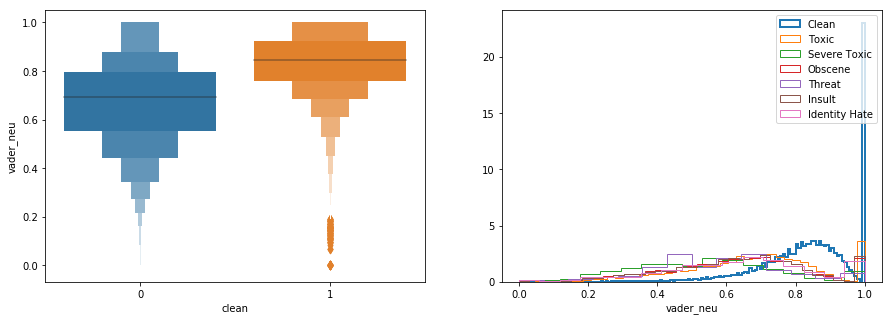

In [228]:
plot_feature(df_train, 'vader_neu')#, lv_ylim=(0, 30), hist_xlim=(0, 10))

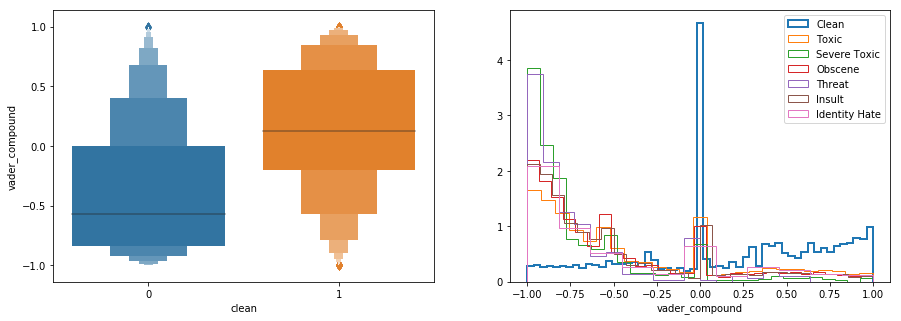

In [243]:
plot_feature(df_train, 'vader_compound')#, lv_ylim=(0, 30), hist_xlim=(0, 10))

In [254]:
# Save temp without actual text to save memory, can be joined afterwords
df_train.drop(columns=['comment_text','spacy_words']).to_pickle('df_train_0')

In [2]:
import pickle

In [3]:
with open('df_train_0', 'r') as f:
    df_train = pickle.load(f)

# Training/Model

## Split Train-Test

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
features = ['num_words','num_chars','avg_word_len','cap_chars','ratio_cap_chars','num_punc',
            'num_excl','ratio_excl','num_q','ratio_q','num_lines','num_excess_char',
            'repeated_words','num_spacy_words','num_non_stop','num_oov','ratio_oov','num_you',
            'ratio_you','repeat_spacy_words','country_mentions','bad_words','num_url',
            'num_spacy_url','vader_neg','vader_pos','vader_neu','vader_compound',
            'ratio_repeat_spacy_words','unique_spacy_words','ratio_unique_spacy_words']

In [7]:
X = df_train[features]
y = df_train[class_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
train_class_counts = []
train_class_counts.append(sum(y_train.clean.values))
train_class_counts.append(sum(y_train.toxic.values))
train_class_counts.append(sum(y_train.severe_toxic.values))
train_class_counts.append(sum(y_train.obscene.values))
train_class_counts.append(sum(y_train.threat.values))
train_class_counts.append(sum(y_train.insult.values))
train_class_counts.append(sum(y_train.identity_hate.values))

In [9]:
test_class_counts = []
test_class_counts.append(sum(y_test.clean.values))
test_class_counts.append(sum(y_test.toxic.values))
test_class_counts.append(sum(y_test.severe_toxic.values))
test_class_counts.append(sum(y_test.obscene.values))
test_class_counts.append(sum(y_test.threat.values))
test_class_counts.append(sum(y_test.insult.values))
test_class_counts.append(sum(y_test.identity_hate.values))

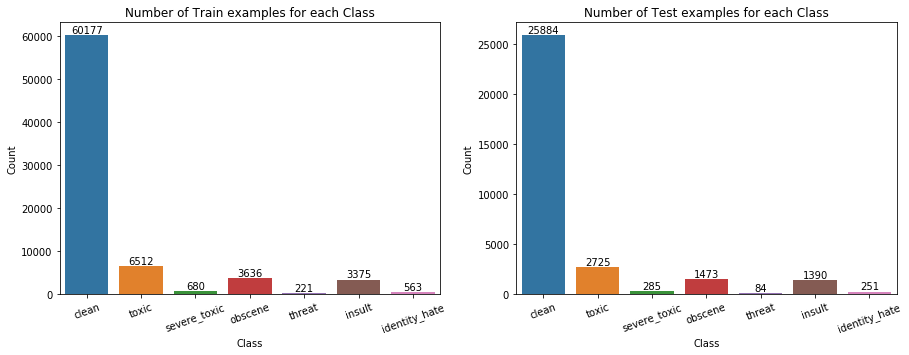

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(121)
ax = sns.barplot(np.arange(7), train_class_counts)
plt.title('Number of Train examples for each Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(np.arange(7), class_names, rotation=20)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

plt.subplot(122)

ax = sns.barplot(np.arange(7), test_class_counts)
plt.title('Number of Test examples for each Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(np.arange(7), class_names, rotation=20)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

plt.show()

In [11]:
y_train = y_train.drop(columns=['clean'])
y_test = y_test.drop(columns=['clean'])

## Setup Model

In [12]:
import xgboost as xgb

In [16]:
from sklearn.metrics import log_loss

In [13]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 5
}

In [17]:
xgb_test = []
for c in class_names[1:]:
    print c
    dtrain = xgb.DMatrix(X_train, label=y_train[[c]])
    dtest = xgb.DMatrix(X_test, label=y_test[[c]])
    
    bst = xgb.train(xgb_params, dtrain, 500, [(dtrain, 'train'), (dtest, 'test')],
                    early_stopping_rounds=50, verbose_eval=10)
    xgb_test.append(log_loss(y_test[[c]].values.transpose()[0], bst.predict(dtest)))

toxic
[0]	train-logloss:0.49591	test-logloss:0.497365
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.145889	test-logloss:0.158064
[20]	train-logloss:0.127941	test-logloss:0.149592
[30]	train-logloss:0.12125	test-logloss:0.149266
[40]	train-logloss:0.117271	test-logloss:0.149482
[50]	train-logloss:0.113012	test-logloss:0.150038
[60]	train-logloss:0.108039	test-logloss:0.151115
[70]	train-logloss:0.104685	test-logloss:0.152063
Stopping. Best iteration:
[27]	train-logloss:0.12325	test-logloss:0.149184

severe_toxic
[0]	train-logloss:0.445675	test-logloss:0.445802
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.035736	test-logloss:0.039925
[20]	train-logloss:0.018621	test-logloss:0.025944
[30]	train-logloss:0.016009	test-logloss:0.025583
[40]	train-

In [19]:
np.mean(xgb_test)

0.06707785685807828

## Improve features

In [20]:
dtoxic = xgb.DMatrix(X_train, label=y_train[['toxic']])
dtoxic_test = xgb.DMatrix(X_test, label=y_test[['toxic']])
bst_toxic = xgb.train(xgb_params, dtoxic, 500, [(dtoxic, 'train'), (dtoxic_test, 'test')],
                     early_stopping_rounds=50)

[0]	train-logloss:0.49591	test-logloss:0.497365
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.395824	test-logloss:0.398218
[2]	train-logloss:0.309201	test-logloss:0.313091
[3]	train-logloss:0.262679	test-logloss:0.267432
[4]	train-logloss:0.222253	test-logloss:0.228172
[5]	train-logloss:0.195537	test-logloss:0.202666
[6]	train-logloss:0.177483	test-logloss:0.185707
[7]	train-logloss:0.165062	test-logloss:0.174116
[8]	train-logloss:0.156392	test-logloss:0.166339
[9]	train-logloss:0.15087	test-logloss:0.16201
[10]	train-logloss:0.145889	test-logloss:0.158064
[11]	train-logloss:0.141912	test-logloss:0.155459
[12]	train-logloss:0.139145	test-logloss:0.15358
[13]	train-logloss:0.136864	test-logloss:0.152329
[14]	train-logloss:0.134988	test-logloss:0.151604
[15]	train-logloss:0.133498	test-logloss:0.151068
[16]	train-logloss:0.132167	test-logloss:0.150509
[17]	train-logl

In [21]:
fps = []
fns = []
dalldata = xgb.DMatrix(df_train[features])
for i, (actual, predicted) in enumerate(zip(df_train[['toxic']].values.transpose()[0], bst_toxic.predict(dalldata))):
    diff = actual - predicted
    if diff > 0:
        fns.append((i, diff, actual, predicted))
    else:
        fps.append((i, diff, actual, predicted))
fps = sorted(fps, key=lambda x: x[1])
fns = sorted(fns, key=lambda x: -x[1])

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
confusion_matrix(df_train[['toxic']].values.transpose()[0], map(lambda x: 0 if x < 0.5 else 1, bst_toxic.predict(dalldata)))
# Big false negative problem

array([[85769,   845],
       [ 2980,  6257]])

In [29]:
# Examples of False Positive, i.e. called toxic incorrectly
get_comment_examples(df_train.loc[map(lambda x: x[0], fps)[:10]], 10)

AttributeError: 'DataFrame' object has no attribute 'comment_text'

In [658]:
# Example of False Negative, i.e. should've been called toxic
get_comment_examples(df_train.loc[map(lambda x: x[0], fns)[:10]], 10)

Example 1
LOL what a load of unsourced, unscientific bullcrap 
What about making this article more scientific so people can actually use it?? There is no technical info.  Come on, it doesn't take an university degree to describe it. It's merely selective breeding, it is well documented and has been practiced for 1000's of years with animals. It shouldn't be hard to describe the science behind it as the mechanisms are exactly the same with humans. There are no principal differences between breeding an intelligent search dog and an intelligent human, the method is the same. 93.161.107.169
Example 2
"
You shoot your entire imbecilic argument in the head with the silly claim about ""10 cars go past per day, tops"".   I've driven the Stuart Highway several times and never passed less than 10 cars per hour,  in quiet times.  Thats less than freeways overseas but still a lot more traffic than ""10 cars per day"".  
"
Example 3
" (UTC)

And what would you say otherwise? He hates ""gays""? He i

In [ ]:
# From here would look at examples of what was wrong and improve from there.